# SPEXone Level 2 AOD - AOI Processing, Gridding, and Visualization (Multi-File, using h5py)

## About

This notebook loads data from multiple SPEXone Level 2 NetCDF files using `h5py`, processes them for a user-defined Area of Interest (AOI), and performs the following:
1. Extracts latitude, longitude, AOD@550nm, quality flags, UTC date, and fractional day.
2. Calculates datetime objects.
3. Filters data for the specified AOI and good quality flags.
4. Visualizes a combined AOD map for the AOI.
5. Saves two ASCII (CSV) files:
    a. All individual good-quality pixel data within the AOI.
    b. Gridded mean AOD values within the AOI.

## Step 1: Load Python Libraries

In [1]:
import h5py 
import numpy as np
import os
import datetime
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings, AOI Definition, and File Discovery

In [2]:
# --- User Settings --- #
file_pattern = '../data/spexone_aod/PACE_SPEXONE*.nc' 
output_image_dir = '../output/images/'
output_ascii_dir = '../output/ascii/'

lat_min_aoi = 7.0   
lat_max_aoi = 23.0
lon_min_aoi = 95.0
lon_max_aoi = 110.0

grid_resolution = 0.25 
# --- End User Settings --- #

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_ascii_dir, exist_ok=True)

file_list = sorted(glob.glob(file_pattern))

if not file_list:
    print(f"No files found matching pattern: {file_pattern}")
else:
    print(f"Found {len(file_list)} files matching pattern: {file_pattern}")

Found 8 files matching pattern: ../data/spexone_aod/PACE_SPEXONE*.nc


## Step 3: Load Data using `h5py`, Process, Clip to AOI, and Aggregate

In [3]:
# Lists to store data for combined plotting (only data within AOI after processing)
latitude_all_granules = []
longitude_all_granules = []
aot550_for_plot_all_granules = []

# Lists for the first ASCII file (all valid pixels within AOI)
ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_aot = []
ascii_pixels_qf = []

# Lists for data to be gridded (valid pixels within AOI)
lat_for_gridding = []
lon_for_gridding = []
aod_for_gridding = []

var_attributes = {} # To store attributes from the first file
any_file_processed_successfully = False
base_nc_filename_for_output = "SPEXone_AOD_Combined_AOI" # DEFAULT User-defined base filename

if file_list:
    for i, file_path in enumerate(file_list):
        print(f"Processing file: {file_path}")
        hf = None
        try:
            hf = h5py.File(file_path, 'r')
            
            lat_granule_raw = hf['geolocation_data/latitude'][:]
            lon_granule_raw = hf['geolocation_data/longitude'][:]
            aot550_raw_granule = hf['geophysical_data/aot550'][:]
            qf_raw_granule = hf['diagnostic_data/quality_flag'][:]
            utc_date_granule_raw = hf['geolocation_data/utc_date'][:]
            fracday_granule_raw = hf['geolocation_data/fracday'][:]

            if not var_attributes: 
                aot_ds = hf['geophysical_data/aot550']
                qf_ds = hf['diagnostic_data/quality_flag']
                lat_ds = hf['geolocation_data/latitude']
                lon_ds = hf['geolocation_data/longitude']

                def get_attr_decoded(h5_dataset, attr_name, default_value):
                    attr_val = h5_dataset.attrs.get(attr_name, default_value)
                    if isinstance(attr_val, bytes):
                        return attr_val.decode('utf-8', 'ignore')
                    return attr_val

                var_attributes['AOT550_long_name'] = get_attr_decoded(aot_ds, 'long_name', 'AOT at 550nm')
                var_attributes['AOT550_units'] = get_attr_decoded(aot_ds, 'units', '1')
                var_attributes['AOT550_fill_value'] = aot_ds.attrs.get('_FillValue', np.float32(-32767.0))
                var_attributes['QF_fill_value'] = qf_ds.attrs.get('_FillValue', np.int32(-32767))
                var_attributes['Geo_Lat_fill_value'] = lat_ds.attrs.get('_FillValue', np.float32(-32767.0))
                var_attributes['Geo_Lon_fill_value'] = lon_ds.attrs.get('_FillValue', np.float32(-32767.0))
            
            aot_fill = np.float32(var_attributes['AOT550_fill_value'])
            qf_fill = np.int32(var_attributes['QF_fill_value'])
            geo_lat_fill = np.float32(var_attributes['Geo_Lat_fill_value'])
            geo_lon_fill = np.float32(var_attributes['Geo_Lon_fill_value'])

            aot_processed_granule = np.where(aot550_raw_granule == aot_fill, np.nan, aot550_raw_granule)
            qf_processed_granule = np.where(qf_raw_granule == qf_fill, -1, qf_raw_granule).astype(np.int16)
            
            aoi_mask = (lat_granule_raw >= lat_min_aoi) & (lat_granule_raw <= lat_max_aoi) & \
                         (lon_granule_raw >= lon_min_aoi) & (lon_granule_raw <= lon_max_aoi) & \
                         (lat_granule_raw != geo_lat_fill) & (lon_granule_raw != geo_lon_fill)

            aot_for_plot_granule = np.where((qf_processed_granule == 0) & aoi_mask, aot_processed_granule, np.nan)
            
            latitude_all_granules.append(lat_granule_raw)
            longitude_all_granules.append(lon_granule_raw)
            aot550_for_plot_all_granules.append(aot_for_plot_granule)

            if np.any(~np.isnan(aot_for_plot_granule)):
                any_file_processed_successfully = True

            for y_idx in range(lat_granule_raw.shape[0]):
                for x_idx in range(lat_granule_raw.shape[1]):
                    if aoi_mask[y_idx, x_idx] and qf_processed_granule[y_idx, x_idx] == 0 and \
                       not np.isnan(aot_processed_granule[y_idx, x_idx]):
                        
                        date_int = utc_date_granule_raw[y_idx, x_idx]
                        frac_day_val = fracday_granule_raw[y_idx, x_idx]
                        dt_obj = None
                        if date_int != qf_fill and frac_day_val != aot_fill and not np.isnan(frac_day_val):
                            try:
                                year = int(str(int(date_int))[:4])
                                month = int(str(int(date_int))[4:6])
                                day = int(str(int(date_int))[6:8])
                                base_date = datetime.date(year, month, day)
                                seconds_in_day = float(frac_day_val) * 24 * 60 * 60
                                time_delta = datetime.timedelta(seconds=seconds_in_day)
                                dt_obj = datetime.datetime.combine(base_date, datetime.time.min) + time_delta
                            except ValueError:
                                dt_obj = None 
                        
                        if dt_obj is not None:
                            ascii_pixels_datetime.append(dt_obj)
                            ascii_pixels_lat.append(lat_granule_raw[y_idx, x_idx])
                            ascii_pixels_lon.append(lon_granule_raw[y_idx, x_idx])
                            ascii_pixels_aot.append(aot_processed_granule[y_idx, x_idx])
                            ascii_pixels_qf.append(qf_processed_granule[y_idx, x_idx])
                            
                            lat_for_gridding.append(lat_granule_raw[y_idx, x_idx])
                            lon_for_gridding.append(lon_granule_raw[y_idx, x_idx])
                            aod_for_gridding.append(aot_processed_granule[y_idx, x_idx])
        except Exception as e:
            print(f"Error processing file {file_path} with h5py: {e}")
            continue
        finally:
            if hf:
                hf.close()
    
    if any_file_processed_successfully and latitude_all_granules:
        print(f"\nSuccessfully extracted and processed data from {len(latitude_all_granules)} out of {len(file_list)} files.")
        # Use the user-defined base filename if multiple files, otherwise derive from single file
        if len(file_list) > 1:
            base_nc_filename_for_output = "SPEXone_AOD_Combined_AOI" 
            # If you want to add date range to this generic name, you can parse it from file_list[0] and file_list[-1]
            # Example: 
            # first_date_part = os.path.splitext(os.path.basename(file_list[0]))[0].split('.')[1] 
            # last_date_part = os.path.splitext(os.path.basename(file_list[-1]))[0].split('.')[1] 
            # if first_date_part != last_date_part: 
            #     base_nc_filename_for_output = f"SPEXone_AOD_Combined_{first_date_part}_to_{last_date_part}_AOI"
            # else: 
            #     base_nc_filename_for_output = f"SPEXone_AOD_Combined_{first_date_part}_AOI"
        elif file_list:
            base_nc_filename_for_output = f"{os.path.splitext(os.path.basename(file_list[0]))[0]}_AOI"
    else:
        print("No data successfully extracted or processed from any files.")
        data_available_for_plotting = False 

    print("Data loading and initial processing complete.")
else:
    print("File list is empty. Nothing to process.")

Processing file: ../data/spexone_aod/PACE_SPEXONE.20240316T062011.V2.L2.AER_LAND_REMOTAP.nc
Processing file: ../data/spexone_aod/PACE_SPEXONE.20240316T062011.V2.L2.AER_OCEAN_REMOTAP.nc
Processing file: ../data/spexone_aod/PACE_SPEXONE.20240316T062511.V2.L2.AER_LAND_REMOTAP.nc
Processing file: ../data/spexone_aod/PACE_SPEXONE.20240316T062511.V2.L2.AER_OCEAN_REMOTAP.nc
Processing file: ../data/spexone_aod/PACE_SPEXONE.20240316T074332.V2.L2.AER_OCEAN_REMOTAP.nc
Processing file: ../data/spexone_aod/PACE_SPEXONE.20240316T074832.V2.L2.AER_OCEAN_REMOTAP.nc
Processing file: ../data/spexone_aod/PACE_SPEXONE.20240321T060358.V2.L2.AER_LAND_REMOTAP.nc
Processing file: ../data/spexone_aod/PACE_SPEXONE.20240321T060358.V2.L2.AER_OCEAN_REMOTAP.nc

Successfully extracted and processed data from 8 out of 8 files.
Data loading and initial processing complete.


## Step 4: Define Map Extent (Based on AOI)

In [4]:
map_extent_aoi_plot = None
if any_file_processed_successfully: 
    padding = 1.0 
    map_extent_aoi_plot = [lon_min_aoi - padding, lon_max_aoi + padding, 
                           lat_min_aoi - padding, lat_max_aoi + padding]
    print(f"Map extent for AOI plotting (with padding): {map_extent_aoi_plot}")
else:
    print("Cannot define map extent as no data was loaded or attributes are missing.")

Map extent for AOI plotting (with padding): [94.0, 111.0, 6.0, 24.0]


## Step 5: Visualize and Save Combined & Clipped AOD Map

AOI AOD Map saved to: ../output/images/SPEXone_AOD_Combined_AOI_AOT550_QF0_AOI.png


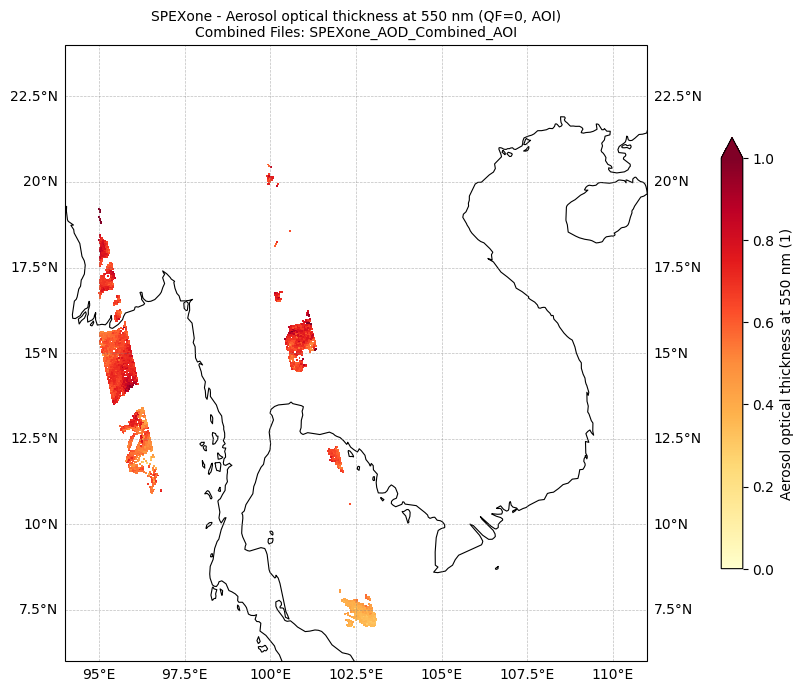

In [5]:
if any_file_processed_successfully and map_extent_aoi_plot is not None:
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax.set_extent(map_extent_aoi_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_aoi_plot}: {e}. Attempting to use broader extent or global.")
        if longitude_all_granules and latitude_all_granules:
            all_lons_flat_list = [lon.ravel() for lon in longitude_all_granules if lon.size > 0]
            all_lats_flat_list = [lat.ravel() for lat in latitude_all_granules if lat.size > 0]
            if all_lons_flat_list and all_lats_flat_list:
                all_lons_flat = np.concatenate(all_lons_flat_list)
                all_lats_flat = np.concatenate(all_lats_flat_list)
                geo_lat_fill = var_attributes.get('Geo_Lat_fill_value', np.float32(-32767.0))
                geo_lon_fill = var_attributes.get('Geo_Lon_fill_value', np.float32(-32767.0))
                all_lons_flat_valid = all_lons_flat[(all_lons_flat != geo_lon_fill) & (~np.isnan(all_lons_flat))]
                all_lats_flat_valid = all_lats_flat[(all_lats_flat != geo_lat_fill) & (~np.isnan(all_lats_flat))]
                if all_lons_flat_valid.size > 0 and all_lats_flat_valid.size > 0:
                    ax.set_extent([np.nanmin(all_lons_flat_valid)-1, np.nanmax(all_lons_flat_valid)+1, 
                                     np.nanmin(all_lats_flat_valid)-1, np.nanmax(all_lats_flat_valid)+1], 
                                    crs=ccrs.PlateCarree())
                else:
                    ax.set_global()
            else:
                 ax.set_global()
        else:
            ax.set_global()
    
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = True # Keep right labels for vertical colorbar
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_aod = None 
    
    for i in range(len(longitude_all_granules)):
        lon_granule = longitude_all_granules[i]
        lat_granule = latitude_all_granules[i]
        aod_to_plot = aot550_for_plot_all_granules[i]

        if aod_to_plot.size > 0 and np.any(~np.isnan(aod_to_plot)):
            mesh = ax.pcolormesh(lon_granule, lat_granule, aod_to_plot, 
                                 transform=ccrs.PlateCarree(), 
                                 cmap='YlOrRd', 
                                 vmin=0, 
                                 vmax=1.0, 
                                 shading='auto')
            if plotted_mesh_aod is None: 
                plotted_mesh_aod = mesh
    
    aot550_display_long_name = var_attributes.get('AOT550_long_name', 'AOT at 550nm')
    aot550_display_units = var_attributes.get('AOT550_units', '1')
    title_str_prefix = f'SPEXone - {aot550_display_long_name} (QF=0, AOI)'
    
    # Use the globally set base_nc_filename_for_output for the title suffix
    title_str_suffix = base_nc_filename_for_output
    if len(file_list) > 1: 
        title_str_main = f'{title_str_prefix}\nCombined Files: {title_str_suffix}'
    elif file_list:
        title_str_main = f'{title_str_prefix}\n{os.path.basename(file_list[0])}'
    else:
        title_str_main = f'{title_str_prefix}\nNo files loaded'

    if plotted_mesh_aod is not None:
        cbar = plt.colorbar(plotted_mesh_aod, ax=ax, orientation='vertical', pad=0.08, shrink=0.7, extend='max')
        cbar.set_label(f"{aot550_display_long_name} ({aot550_display_units})")
        plt.title(title_str_main, fontsize=10)
    else:
        print("No valid AOD data within AOI to plot across all granules.")
        plt.title(f'{title_str_prefix}\nNo valid data in AOI from loaded files', fontsize=10)
    
    save_filename_aod = f"{base_nc_filename_for_output}_AOT550_QF0_AOI.png"
    full_save_path_aod = os.path.join(output_image_dir, save_filename_aod)
    plt.savefig(full_save_path_aod, dpi=300, bbox_inches='tight') 
    print(f"AOI AOD Map saved to: {full_save_path_aod}")
    plt.show() 
    plt.close(fig)
else:
    print("Skipping AOD map plotting: No plottable data available or map extent could not be determined.")

## Step 6: Create Gridded Mean AOD for AOI

In [6]:
gridded_mean_aod_for_ascii = [] 

if any_file_processed_successfully and lat_for_gridding and map_extent_aoi_plot is not None:
    print(f"\nCalculating gridded mean AOD for AOI with {grid_resolution}-degree resolution...")
    
    np_lat_for_gridding = np.array(lat_for_gridding)
    np_lon_for_gridding = np.array(lon_for_gridding)
    np_aod_for_gridding = np.array(aod_for_gridding)

    epsilon = 1e-6 
    lon_bins = np.arange(lon_min_aoi, lon_max_aoi + grid_resolution + epsilon, grid_resolution)
    lat_bins = np.arange(lat_min_aoi, lat_max_aoi + grid_resolution + epsilon, grid_resolution)
    
    if len(lon_bins) < 2 or len(lat_bins) < 2:
        print("Warning: Grid resolution too large for AOI, or AOI is too small. Cannot create grid.")
    else:
        aod_sum_in_bins, _, _ = np.histogram2d(
            np_lat_for_gridding, 
            np_lon_for_gridding, 
            bins=[lat_bins, lon_bins],
            weights=np_aod_for_gridding 
        )
        
        points_in_bins, _, _ = np.histogram2d(
            np_lat_for_gridding, 
            np_lon_for_gridding, 
            bins=[lat_bins, lon_bins]
        )
        
        mean_aod_in_bins = np.full_like(aod_sum_in_bins, np.nan)
        valid_bins_mask = points_in_bins > 0
        mean_aod_in_bins[valid_bins_mask] = aod_sum_in_bins[valid_bins_mask] / points_in_bins[valid_bins_mask]
        
        lon_bin_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
        lat_bin_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
        
        for i_lat, lat_center in enumerate(lat_bin_centers):
            for i_lon, lon_center in enumerate(lon_bin_centers):
                mean_aod_val = mean_aod_in_bins[i_lat, i_lon] 
                if not np.isnan(mean_aod_val):
                    gridded_mean_aod_for_ascii.append((lat_center, lon_center, mean_aod_val))
        
        print(f"Calculated gridded mean AOD for {len(gridded_mean_aod_for_ascii)} grid cells.")
else:
    print("Skipping gridded mean AOD calculation: No data available for gridding or AOI not defined.")


Calculating gridded mean AOD for AOI with 0.25-degree resolution...
Calculated gridded mean AOD for 162 grid cells.


## Step 7: Save Extracted Data to ASCII (CSV) Files

In [7]:
# Save ASCII File 1: All valid pixels within AOI
if any_file_processed_successfully and ascii_pixels_datetime:
    # Use the globally defined base_nc_filename_for_output
    ascii_pixels_filename = f"{base_nc_filename_for_output}_pixels.csv"
    full_ascii_pixels_path = os.path.join(output_ascii_dir, ascii_pixels_filename)

    print(f"\nSaving all valid AOI pixel data to: {full_ascii_pixels_path}")
    with open(full_ascii_pixels_path, 'w') as f:
        f.write("Datetime,Latitude,Longitude,AOT550_QF0,QualityFlag\n")
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            aot_val = ascii_pixels_aot[i]
            qf_val = ascii_pixels_qf[i]
            
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{aot_val:.4f},{int(qf_val)}\n")
        print(f"Finished writing AOI pixel data. {len(ascii_pixels_datetime)} points written.")
else:
    print("Skipping ASCII file for AOI pixels: No valid data points were processed for output.")

# Save ASCII File 2: Gridded mean AOD within AOI
if any_file_processed_successfully and gridded_mean_aod_for_ascii:
    # Use the globally defined base_nc_filename_for_output
    ascii_gridded_filename = f"{base_nc_filename_for_output}_gridded_mean_{grid_resolution}deg.csv"
    full_ascii_gridded_path = os.path.join(output_ascii_dir, ascii_gridded_filename)

    print(f"\nSaving gridded mean AOD data to: {full_ascii_gridded_path}")
    with open(full_ascii_gridded_path, 'w') as f:
        f.write("Latitude_center,Longitude_center,Mean_AOT550_QF0\n")
        for lat_center, lon_center, mean_aod_val in gridded_mean_aod_for_ascii:
            f.write(f"{lat_center:.4f},{lon_center:.4f},{mean_aod_val:.4f}\n")
        print(f"Finished writing gridded mean AOD data. {len(gridded_mean_aod_for_ascii)} grid cells written.")
else:
    print("Skipping ASCII file for gridded mean AOT: No data was available for gridding.")


Saving all valid AOI pixel data to: ../output/ascii/SPEXone_AOD_Combined_AOI_pixels.csv
Finished writing AOI pixel data. 2099 points written.

Saving gridded mean AOD data to: ../output/ascii/SPEXone_AOD_Combined_AOI_gridded_mean_0.25deg.csv
Finished writing gridded mean AOD data. 162 grid cells written.


## End of Processing

In [8]:
print("Individual NetCDF files were closed automatically after reading (using h5py.File with 'with' or explicit .close()).")
print("--- SPEXone Data Processing Complete ---")

Individual NetCDF files were closed automatically after reading (using h5py.File with 'with' or explicit .close()).
--- SPEXone Data Processing Complete ---
